<a href="https://colab.research.google.com/github/Sobiii/CancerMetastasisPrediction---Ensemble_ML_Techniques/blob/main/CancerMetastasis_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project utilises the WiDS dataset consisting of over 100 features to create a stacked ensemble model for predicting the metastasis period of breast cancer (how long after diagnosis cancer metastasises).

# Imports

In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.5 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
import torch
import torch.nn as nn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.special import expit
import random

# Importing Files

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Load and Unzip files
file_path = '/content/drive/My Drive/widsdatathon2024-challenge2.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

Mounted at /content/drive


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


# Heatmap of Correlation between Features and Target variable

In [4]:
# Correlation between numerical featuress and metastatic_cancer
numerical_columns = train.select_dtypes(include=['int', 'float']).columns
correlation_with_metastatic_cancer = train[numerical_columns].corrwith(train['metastatic_diagnosis_period'])
sorted_correlation = correlation_with_metastatic_cancer.abs().sort_values(ascending=False)
sorted_correlation

metastatic_diagnosis_period    1.000000
patient_age                    0.055231
labor_force_participation      0.039369
family_dual_income             0.036403
education_bachelors            0.033842
                                 ...   
Average of Apr-14              0.000391
veteran                        0.000365
Average of Mar-16              0.000292
rent_burden                    0.000201
home_ownership                 0.000192
Length: 141, dtype: float64

## Correlation HeatMap of Numerical Features and Target Variable

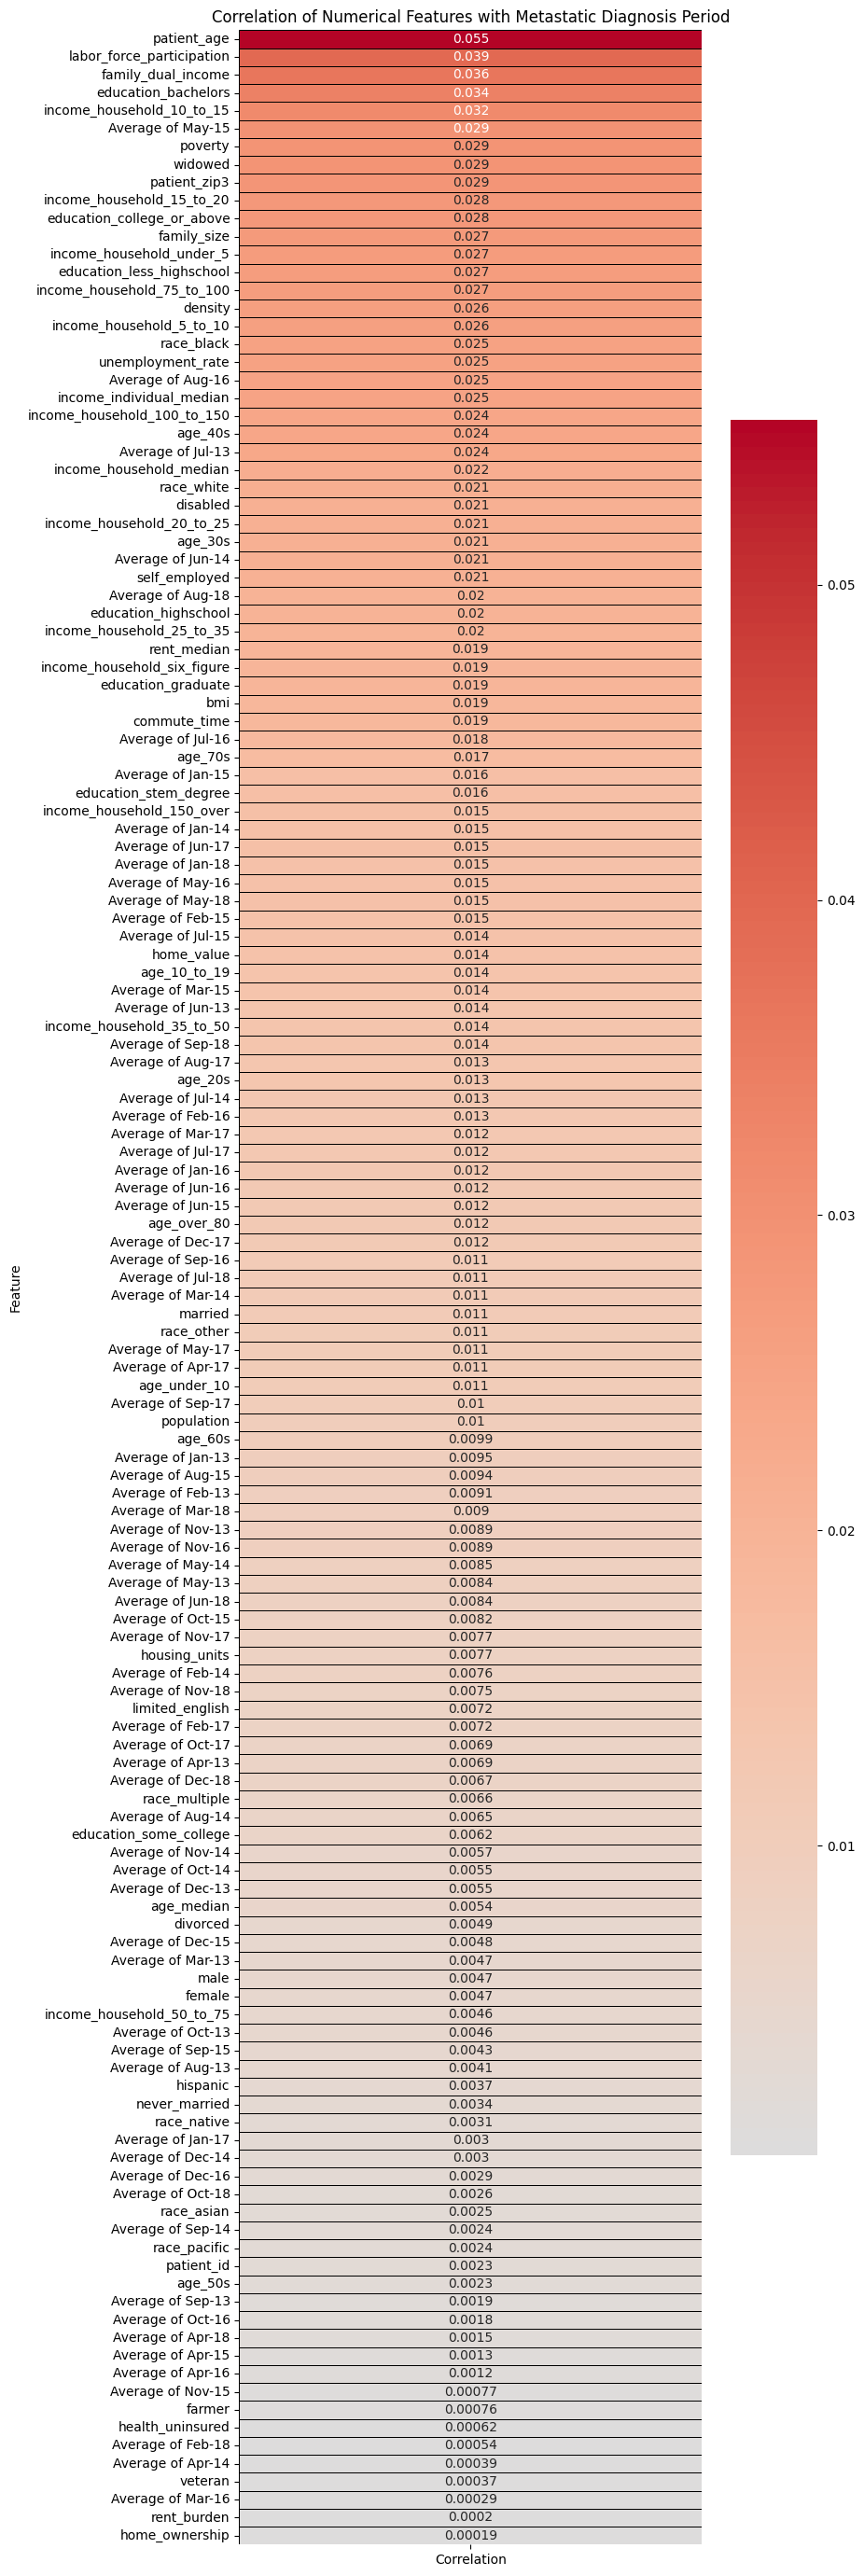

In [5]:
# Convert the correlation to a DataFrame
correlation_df = sorted_correlation.to_frame().reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df = correlation_df[correlation_df['Feature'] != 'metastatic_diagnosis_period']
correlation_df.set_index('Feature', inplace=True)

# Heatmap
plt.figure(figsize=(8,35))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Correlation of Numerical Features with Metastatic Diagnosis Period')
plt.show()

## Correlation HeatMap of Categorical Features and Target Variable

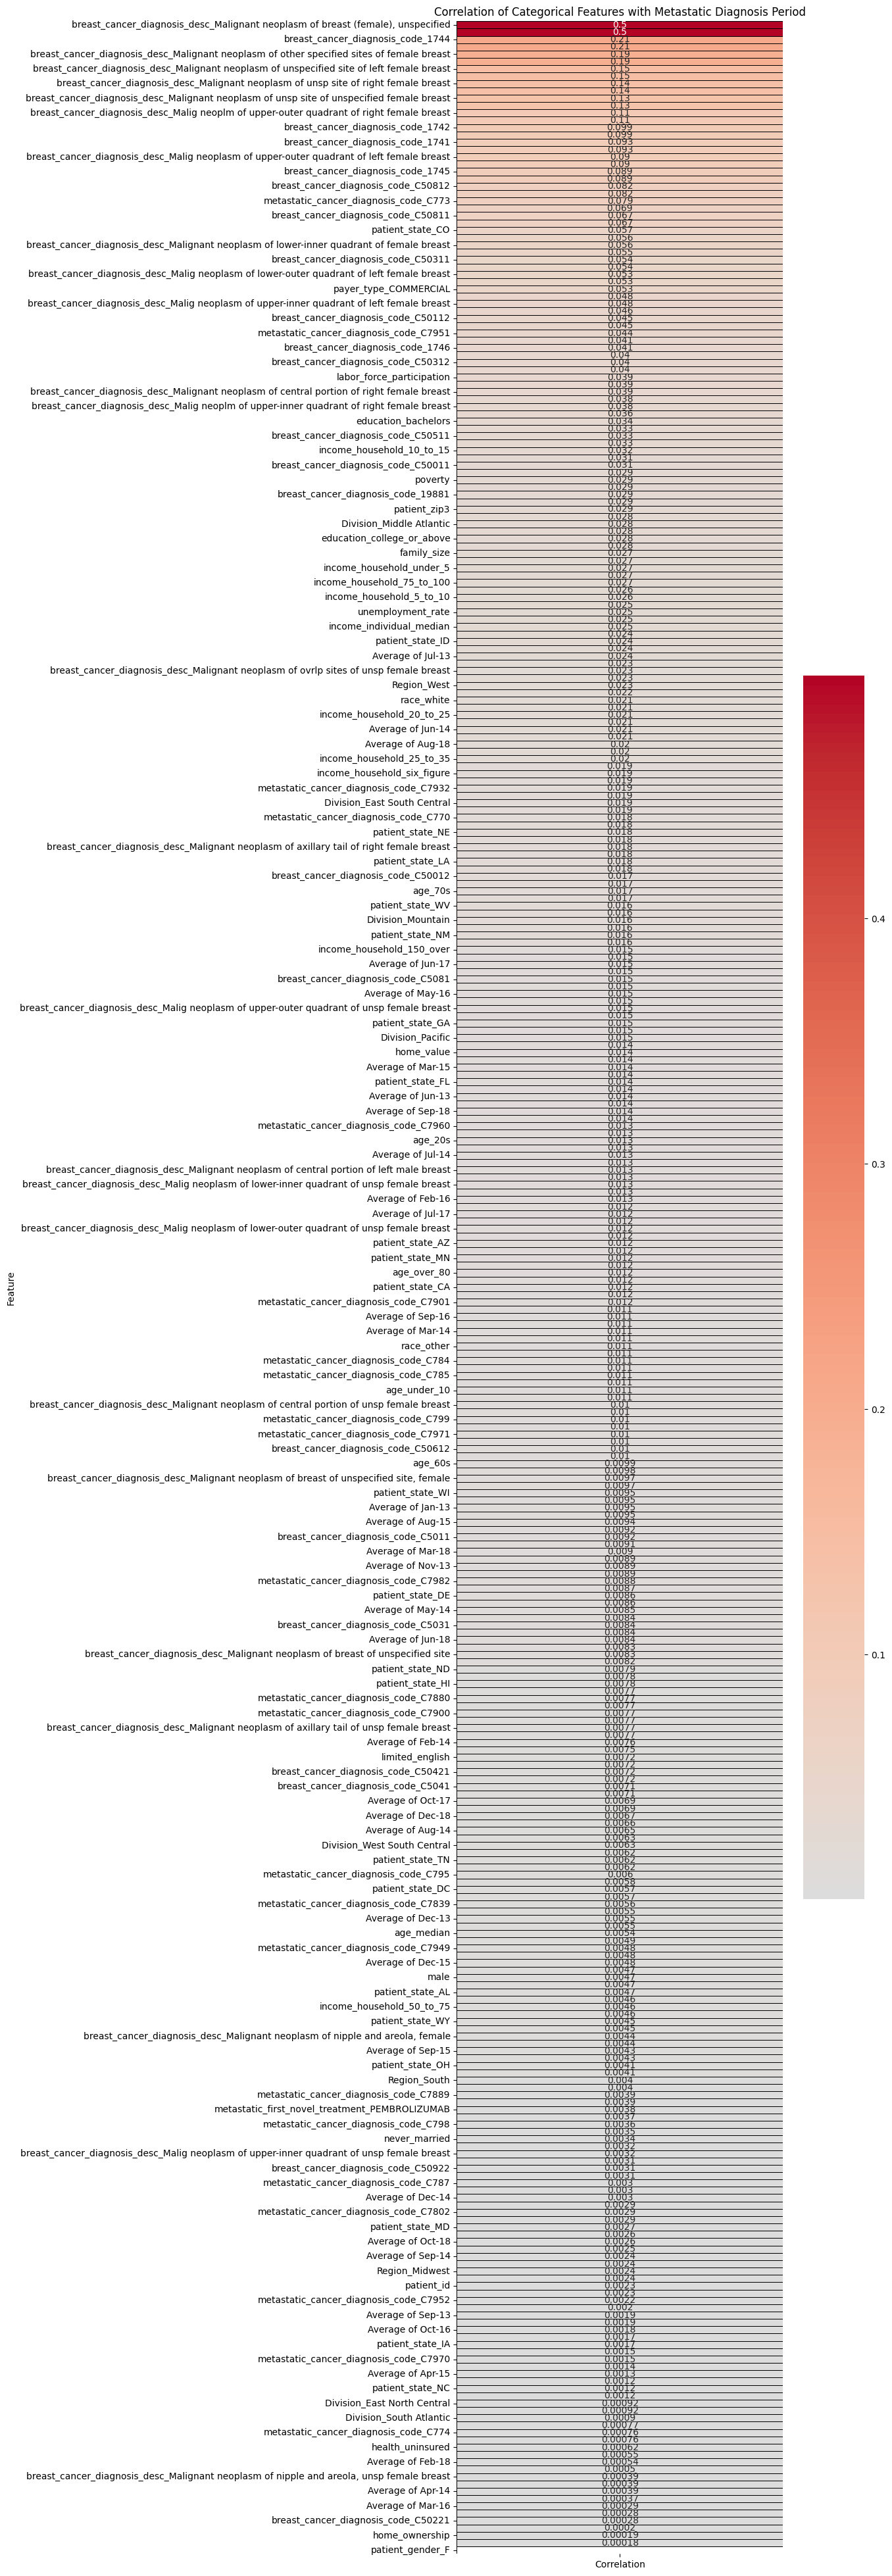

In [6]:
# Select categorical features
categorical_columns = train.select_dtypes(exclude=['int', 'float']).columns.tolist()

# One-hot encode categorical features
one_hot_encoded = pd.get_dummies(train[categorical_columns])
all_features = pd.concat([one_hot_encoded, train[numerical_columns]], axis=1)
correlation_with_metastatic_cancer = all_features.corrwith(train['metastatic_diagnosis_period'])
correlation_with_metastatic_cancer = correlation_with_metastatic_cancer.abs().sort_values(ascending=False)

# Convert to a DataFrame
correlation_df = correlation_with_metastatic_cancer.to_frame().reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df = correlation_df[correlation_df['Feature'] != 'metastatic_diagnosis_period']
correlation_df.set_index('Feature', inplace=True)

# Heatmap
plt.figure(figsize=(8, 50))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Correlation of Categorical Features with Metastatic Diagnosis Period')
plt.show()

# Feature Engineering - Average Temp & Seasonal Averages



*Model only uses Average Temp. Seasonal Features did not perform well*

By condensing monthly average temperatures into a yearly average & seasonal averages, we can simplify the dataset while retaining essential information. This simplification is beneficial for predictive modelling, because it reduces dimensionality without losing significant predictive power.

## Average Temperature

In [7]:
# Regex pattern
pattern = re.compile('^Average of')

# Filter columns
ave_temp_cols = [col for col in train.columns if pattern.match(col)]

# DataFrame containing only matched columns
ave_temp_df = train.loc[:, ave_temp_cols]
ave_temp_df

# Yearly Average
ave_temp_df['Average_temp']= ave_temp_df.mean(axis=1)
ave_temp_df

Average_year_temp = ave_temp_df[['Average_temp']]

## Average Winter Temperature

In [8]:
# Regex patterns
pattern_dec = re.compile('^Average of Dec')
pattern_jan = re.compile('^Average of Jan')
pattern_feb = re.compile('^Average of Feb')

# Filter columns
pattern_match = [col for col in train.columns if pattern_dec.match(col)]
pattern_match += [col for col in train.columns if pattern_jan.match(col)]
pattern_match += [col for col in train.columns if pattern_feb.match(col)]

# DataFrame containing only matched columns
winter_temp_df = train.loc[:, pattern_match]

# Winter Temperature Average
winter_temp_df = winter_temp_df.mean(axis=1)
Average_year_temp['Winter_temp'] = winter_temp_df

<ipython-input-8-e95474b9807a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Winter_temp'] = winter_temp_df


## Average Spring Temperature

In [9]:
# Regex patterns
pattern_march = re.compile('^Average of Mar')
pattern_april = re.compile('^Average of Apr')
pattern_may = re.compile('^Average of May')

# Filter columns
pattern_match = [col for col in train.columns if pattern_march.match(col)]
pattern_match += [col for col in train.columns if pattern_april.match(col)]
pattern_match += [col for col in train.columns if pattern_may.match(col)]

# DataFrame containing only matched columns
spring_temp_df = train.loc[:, pattern_match]

# Spring Temperature Average
spring_temp_df = spring_temp_df.mean(axis=1)
Average_year_temp['Spring_temp'] = spring_temp_df

<ipython-input-9-0056b1505669>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Spring_temp'] = spring_temp_df


## Average Summer Temperature

In [10]:
# Regex patterns
pattern_june = re.compile('^Average of Jun')
pattern_july = re.compile('^Average of Jul')
pattern_august = re.compile('^Average of Aug')

# Filter columns
pattern_match = [col for col in train.columns if pattern_june.match(col)]
pattern_match += [col for col in train.columns if pattern_july.match(col)]
pattern_match += [col for col in train.columns if pattern_august.match(col)]

# DataFrame containing only matched columns
summer_temp_df = train.loc[:, pattern_match]

# Summer Temperature Average
summer_temp_df = summer_temp_df.mean(axis=1)
Average_year_temp['Summer_temp'] = summer_temp_df

<ipython-input-10-ece87f338675>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Summer_temp'] = summer_temp_df


## Average Autumn Temperature

In [11]:
# Regex patterns
pattern_september = re.compile('^Average of Sep')
pattern_october = re.compile('^Average of Oct')
pattern_november = re.compile('^Average of Nov')

# Filter columns
pattern_match = [col for col in train.columns if pattern_september.match(col)]
pattern_match += [col for col in train.columns if pattern_october.match(col)]
pattern_match += [col for col in train.columns if pattern_november.match(col)]

# DataFrame containing only matched columns
autumn_temp_df = train.loc[:, pattern_match]

# Autumn Temperature Average
autumn_temp_df = autumn_temp_df.mean(axis=1)
Average_year_temp['Autumn_temp'] = autumn_temp_df
Average_year_temp

<ipython-input-11-f0c8754d1ee2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Autumn_temp'] = autumn_temp_df


,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp
0,59.083750,38.928889,58.129444,78.365556,60.911111
1,56.399028,35.376111,55.996667,76.002222,58.221111
2,70.011250,57.466667,67.862778,82.916667,71.798889
3,66.694861,60.693333,63.912222,71.974444,70.199444
4,61.847361,54.418889,60.406667,68.240556,64.323333
...,...,...,...,...,...
13168,54.405694,35.226111,51.873333,74.336667,56.186667
13169,66.802083,50.260556,66.135000,82.684444,68.128333
13170,68.743750,60.765556,66.255556,76.016111,71.937778
13171,48.475694,25.986111,46.163889,69.866111,51.886667


Based on domain research, I decided to focus on a curated set of features most likely to influence outcomes.

In [12]:
# Aggregating average yearly temp with other features that I believe are good predcitors
Train = Average_year_temp

Train = pd.merge(Train, train[['metastatic_diagnosis_period','patient_age','bmi','patient_race','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                               'payer_type','health_uninsured','density','farmer','home_ownership','education_college_or_above','family_dual_income','family_size', 'education_bachelors','widowed', 'poverty' ]],
                        left_index=True, right_index=True, how='left')

In [13]:
Train.head()

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,metastatic_diagnosis_period,patient_age,bmi,patient_race,patient_state,...,health_uninsured,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,widowed,poverty
0,59.083750,38.928889,58.129444,78.365556,60.911111,191,39,NaN,NaN,AR,...,8.06,82.63,5.31,72.11,13.32,43.99,3.01,9.21,8.66,19.27
1,56.399028,35.376111,55.996667,76.002222,58.221111,33,55,35.36,White,IL,...,6.93,51.79,5.21,76.71,18.49,41.41,3.17,12.46,8.17,16.94
2,70.011250,57.466667,67.862778,82.916667,71.798889,157,59,NaN,NaN,CA,...,8.07,700.34,0.44,66.82,22.32,52.89,3.80,13.92,4.95,12.72
3,66.694861,60.693333,63.912222,71.974444,70.199444,146,59,NaN,Hispanic,CA,...,10.34,5294.33,0.01,31.50,37.58,55.53,3.44,23.89,4.77,20.76
4,61.847361,54.418889,60.406667,68.240556,64.323333,286,71,NaN,NaN,CA,...,6.54,400.48,1.46,58.81,31.14,51.88,3.09,19.14,5.01,10.34


## Feature Engineering for Test Set

In [14]:
pattern = re.compile('^Average of')
ave_temp_cols = [col for col in test.columns if pattern.match(col)]
ave_temp_df = test.loc[:, ave_temp_cols]
ave_temp_df['Average_temp'] = ave_temp_df.mean(axis=1)
ave_temp_df

Average_year_temp = ave_temp_df[['Average_temp']]

pattern_dec = re.compile('^Average of Dec')
pattern_jan = re.compile('^Average of Jan')
pattern_feb = re.compile('^Average of Feb')

pattern_match = [col for col in test.columns if pattern_dec.match(col)]
pattern_match += [col for col in test.columns if pattern_jan.match(col)]
pattern_match += [col for col in test.columns if pattern_feb.match(col)]

winter_temp_df = test.loc[:, pattern_match]
winter_temp_df = winter_temp_df.mean(axis=1)
Average_year_temp['Winter_temp'] = winter_temp_df

pattern_march = re.compile('^Average of Mar')
pattern_april = re.compile('^Average of Apr')
pattern_may = re.compile('^Average of May')

pattern_match = [col for col in test.columns if pattern_march.match(col)]
pattern_match += [col for col in test.columns if pattern_april.match(col)]
pattern_match += [col for col in test.columns if pattern_may.match(col)]

spring_temp_df = test.loc[:, pattern_match]
spring_temp_df = spring_temp_df.mean(axis=1)
Average_year_temp['Spring_temp'] = spring_temp_df

pattern_june = re.compile('^Average of Jun')
pattern_july = re.compile('^Average of Jul')
pattern_august = re.compile('^Average of Aug')

pattern_match = [col for col in test.columns if pattern_june.match(col)]
pattern_match += [col for col in test.columns if pattern_july.match(col)]
pattern_match += [col for col in test.columns if pattern_august.match(col)]

summer_temp_df = test.loc[:, pattern_match]
summer_temp_df = summer_temp_df.mean(axis=1)
Average_year_temp['Summer_temp'] = summer_temp_df

pattern_september = re.compile('^Average of Sep')
pattern_october = re.compile('^Average of Oct')
pattern_november = re.compile('^Average of Nov')

pattern_match = [col for col in train.columns if pattern_september.match(col)]
pattern_match += [col for col in train.columns if pattern_october.match(col)]
pattern_match += [col for col in train.columns if pattern_november.match(col)]

autumn_temp_df = train.loc[:, pattern_match]
autumn_temp_df = autumn_temp_df.mean(axis=1)
Average_year_temp['Autumn_temp'] = autumn_temp_df
Average_year_temp

<ipython-input-14-71a7553922ed>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Winter_temp'] = winter_temp_df
<ipython-input-14-71a7553922ed>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Average_year_temp['Spring_temp'] = spring_temp_df
<ipython-input-14-71a7553922ed>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp
0,67.190278,51.182778,66.782222,82.047778,60.911111
1,62.713611,45.431111,61.776667,79.788333,58.221111
2,62.565278,44.298333,62.813889,80.196667,71.798889
3,58.604167,40.775000,58.023333,75.451667,70.199444
4,50.061528,37.706667,48.927222,63.180000,64.323333
...,...,...,...,...,...
5641,51.736944,32.837778,49.055000,71.915000,75.654444
5642,61.406806,44.645000,60.622778,77.578333,68.218333
5643,66.347917,60.253333,63.597222,71.789444,50.946667
5644,67.815972,60.891667,65.130556,74.047778,64.299444


In [15]:
# Aggregating average yearly temp with other features that I believe are good predcitors
Test = Average_year_temp

Test = pd.merge(Test, test[['patient_age','bmi','patient_race','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                               'payer_type','health_uninsured','density','farmer','home_ownership','education_college_or_above','family_dual_income','family_size', 'education_bachelors','widowed', 'poverty' ]],
                        left_index=True, right_index=True, how='left')

In [16]:
Test

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,patient_age,bmi,patient_race,patient_state,patient_zip3,...,health_uninsured,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,widowed,poverty
0,67.190278,51.182778,66.782222,82.047778,60.911111,55,NaN,NaN,LA,713,...,8.18,72.66,4.88,74.78,14.94,38.83,3.30,9.74,8.18,27.62
1,62.713611,45.431111,61.776667,79.788333,58.221111,60,40.00,Black,NC,283,...,13.60,217.91,1.40,67.09,18.88,42.57,3.33,12.87,7.96,19.78
2,62.565278,44.298333,62.813889,80.196667,71.798889,54,32.33,NaN,TX,794,...,14.70,1019.51,0.65,47.85,27.74,54.23,3.15,16.37,4.63,23.35
3,58.604167,40.775000,58.023333,75.451667,70.199444,63,27.07,NaN,TN,373,...,10.81,140.05,4.26,78.57,19.02,45.75,2.99,11.97,7.42,15.02
4,50.061528,37.706667,48.927222,63.180000,64.323333,62,NaN,Asian,WA,980,...,5.31,1091.83,0.20,68.62,49.65,58.66,3.12,30.44,4.11,6.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,51.736944,32.837778,49.055000,71.915000,75.654444,63,NaN,White,CO,800,...,7.29,1214.02,0.12,65.86,41.08,62.84,3.23,25.57,3.89,8.68
5642,61.406806,44.645000,60.622778,77.578333,68.218333,57,40.00,NaN,GA,300,...,13.04,875.12,0.31,67.51,40.98,57.21,3.38,24.84,4.31,10.78
5643,66.347917,60.253333,63.597222,71.789444,50.946667,44,NaN,Asian,CA,914,...,9.53,4008.49,0.00,40.38,43.23,59.18,3.33,27.69,4.11,14.36
5644,67.815972,60.891667,65.130556,74.047778,64.299444,66,31.79,White,CA,906,...,7.36,3008.77,0.01,62.41,28.05,60.25,3.77,19.50,5.06,9.34


# Handling Outliers

Previous iterations included Z-score and IQR based outlier removal but resulted in worse performance of the model. This final version does not remove outliers as it better preserves the diversity and variability of the dataset.

In [17]:
Train.describe()

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,metastatic_diagnosis_period,patient_age,bmi,patient_zip3,income_household_median,health_uninsured,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,widowed,poverty
count,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,4102.000000,13173.000000,13168.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13168.000000
mean,57.661889,40.011271,55.967789,74.632085,60.049199,96.515221,59.271313,29.168808,568.530859,74149.173616,8.511348,1776.872376,1.931520,65.895238,31.506428,51.800184,3.196401,19.263585,5.846155,13.417748
std,8.755316,13.645757,8.959022,5.681825,8.360927,108.969873,13.218883,5.752820,275.758485,20425.924830,4.169557,3876.061897,3.194201,14.491534,11.801702,6.696196,0.222907,6.255266,1.556496,5.105035
min,37.540870,9.468889,35.338235,56.629444,38.553889,0.000000,18.000000,15.000000,100.000000,29222.000000,2.440000,0.920000,0.000000,15.850000,7.050000,19.310000,2.550000,2.470000,0.000000,3.430000
25%,50.290972,28.257778,48.682222,70.412778,53.178333,3.000000,50.000000,24.825000,330.000000,61255.110000,5.600000,163.150000,0.040000,56.480000,21.910000,47.732500,3.030000,13.980000,4.770000,9.870000
50%,55.389722,36.718333,54.414444,73.768333,57.620000,44.000000,59.000000,28.580000,557.000000,69729.950000,7.360000,700.340000,0.450000,69.910000,29.790000,52.590000,3.160000,18.870000,5.550000,12.210000
75%,65.948194,50.852222,63.912222,77.788889,67.923333,181.000000,67.000000,33.000000,832.000000,83230.640000,10.390000,1666.520000,2.390000,77.220000,38.720000,56.160000,3.330000,23.890000,6.610000,16.410000
max,77.431806,72.458333,76.048889,93.556111,79.459444,365.000000,91.000000,97.000000,995.000000,164119.200000,27.570000,29851.690000,25.270000,90.370000,77.820000,65.640000,4.170000,41.700000,20.650000,38.350000


## Boxplots of Numerical Features

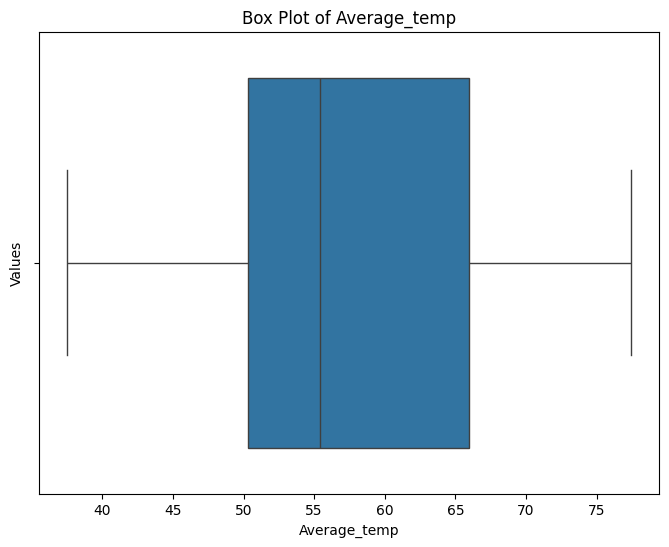

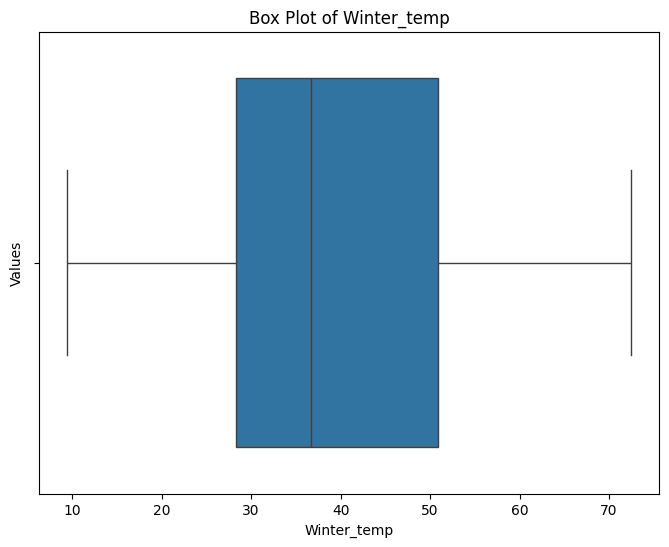

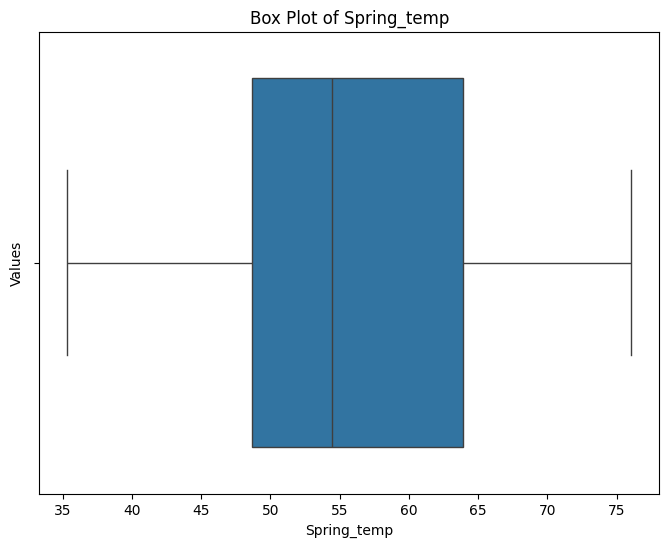

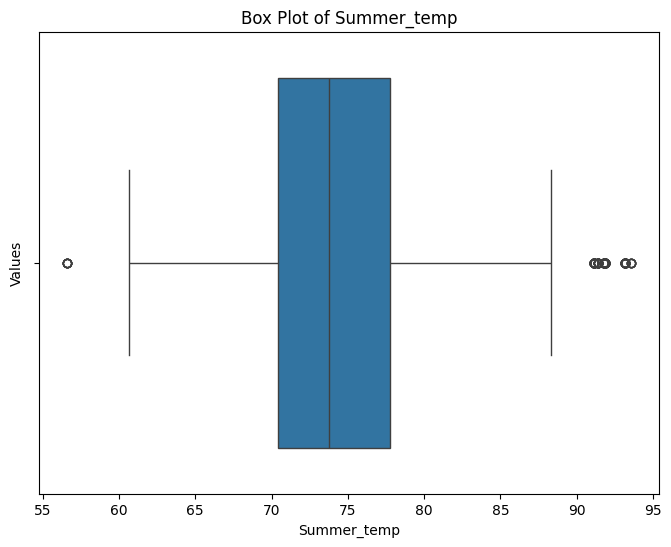

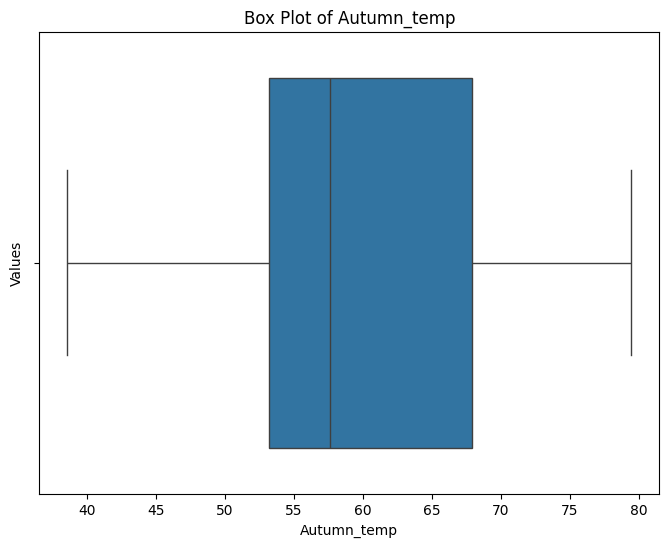

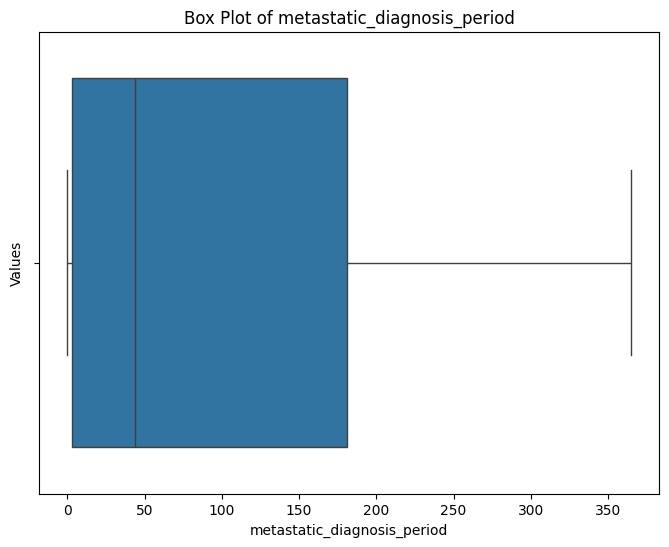

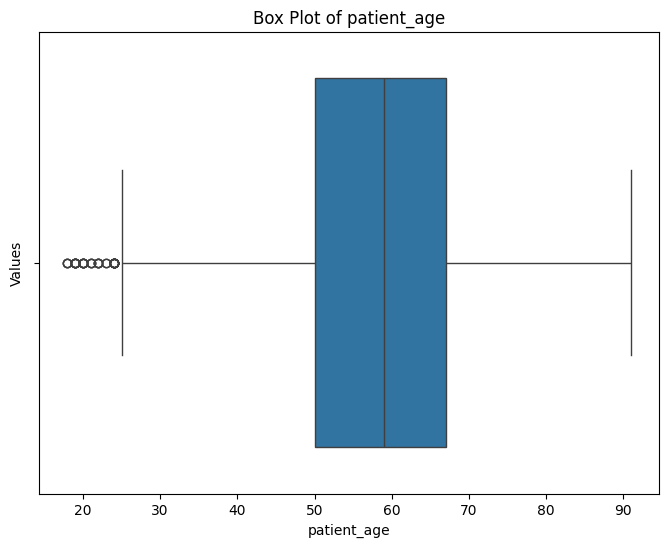

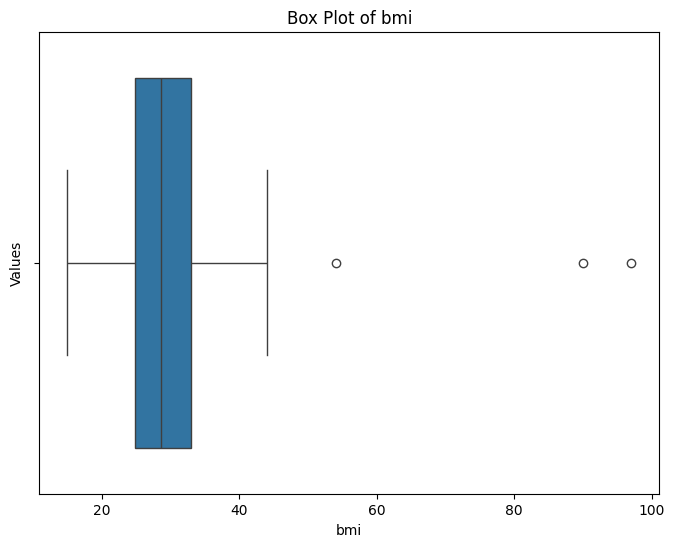

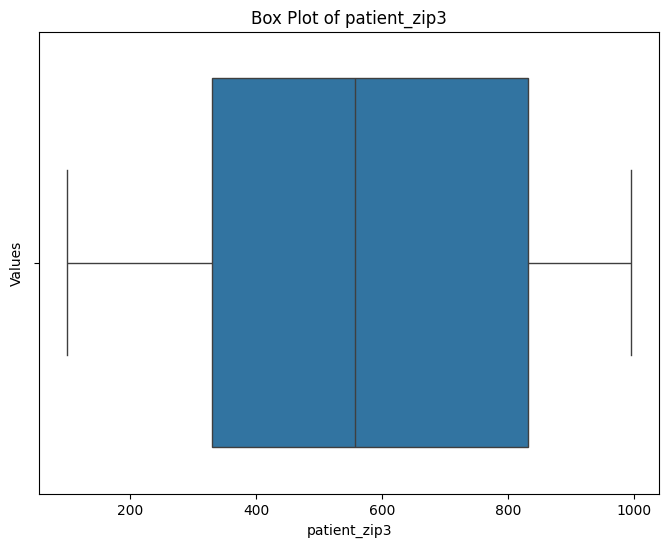

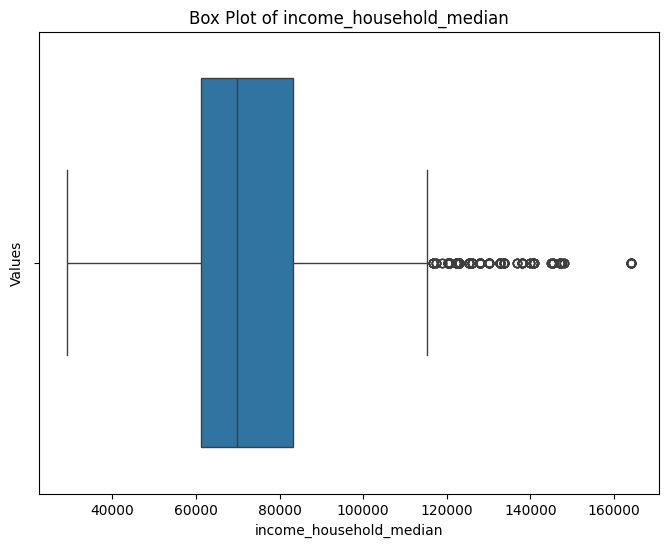

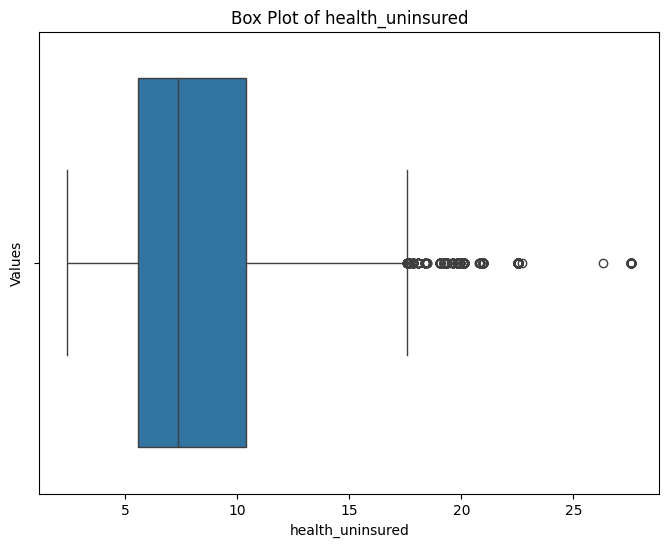

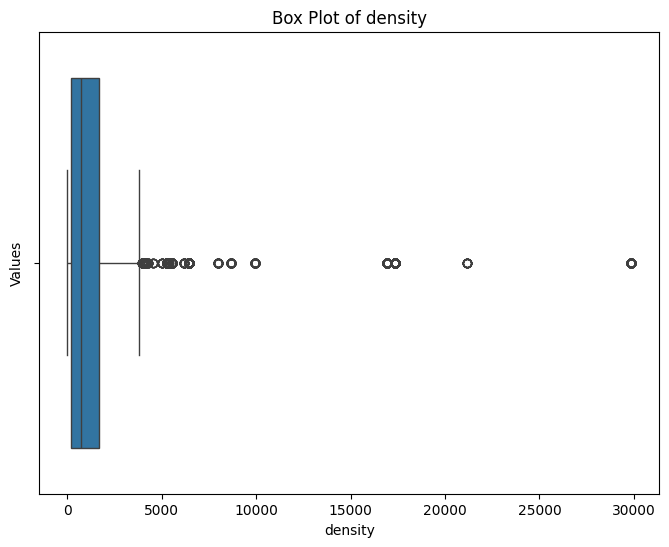

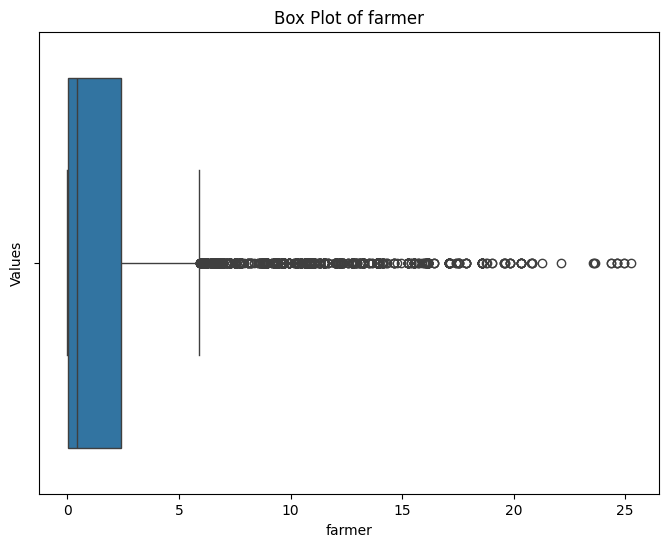

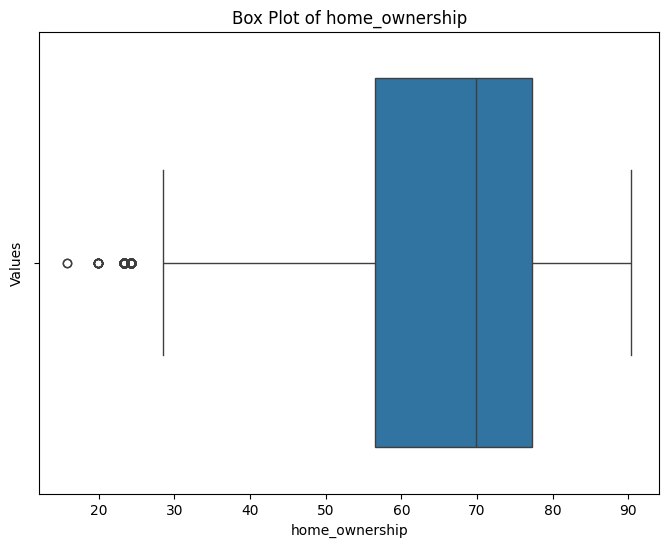

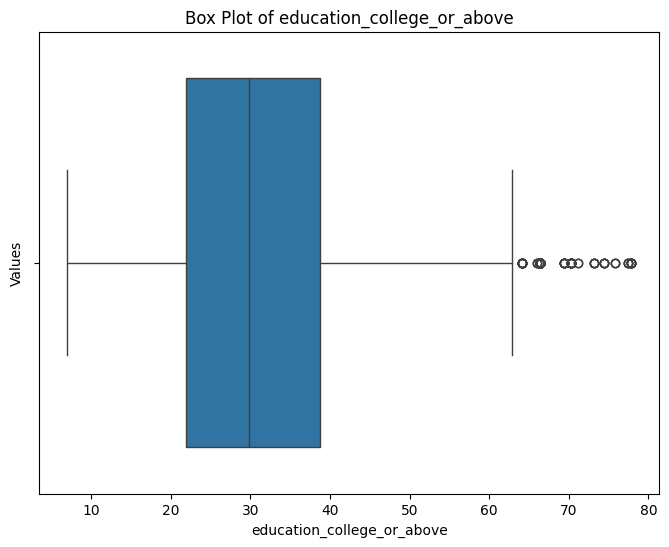

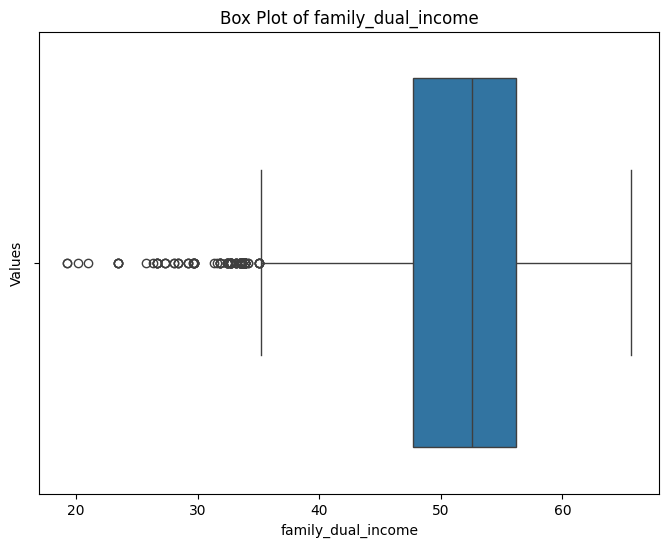

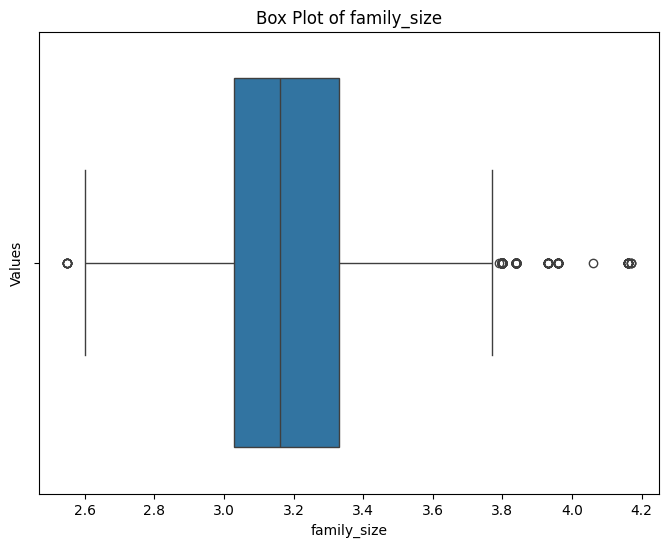

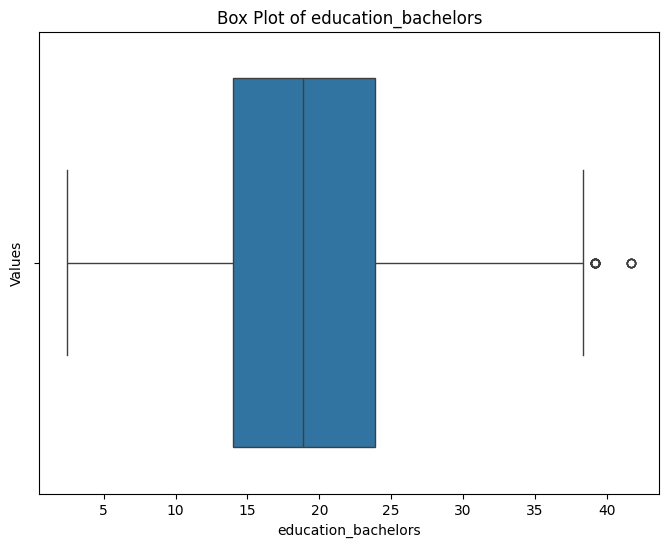

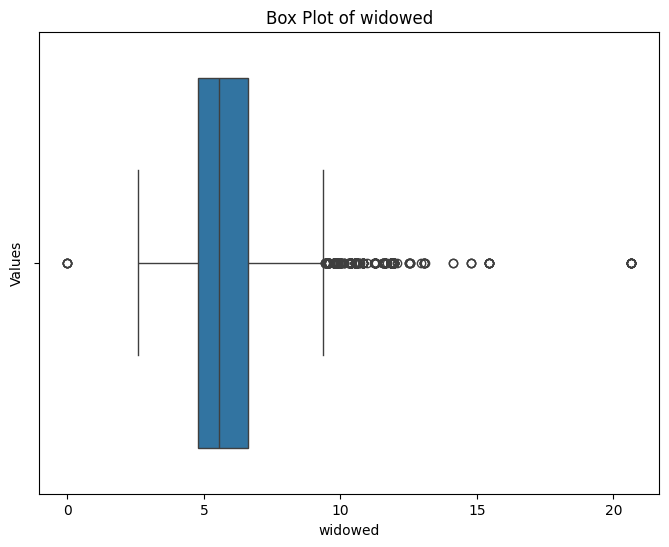

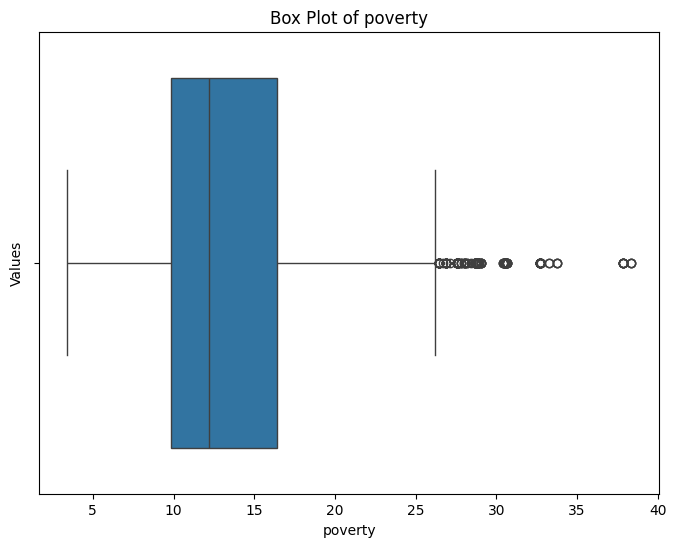

In [18]:
# Numerical columns
numerical_columns = Train.select_dtypes(include='number').columns

# Boxplots for numerical features
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=Train[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Values')
    plt.show()

## Histograms of Numerical Feature Distribution

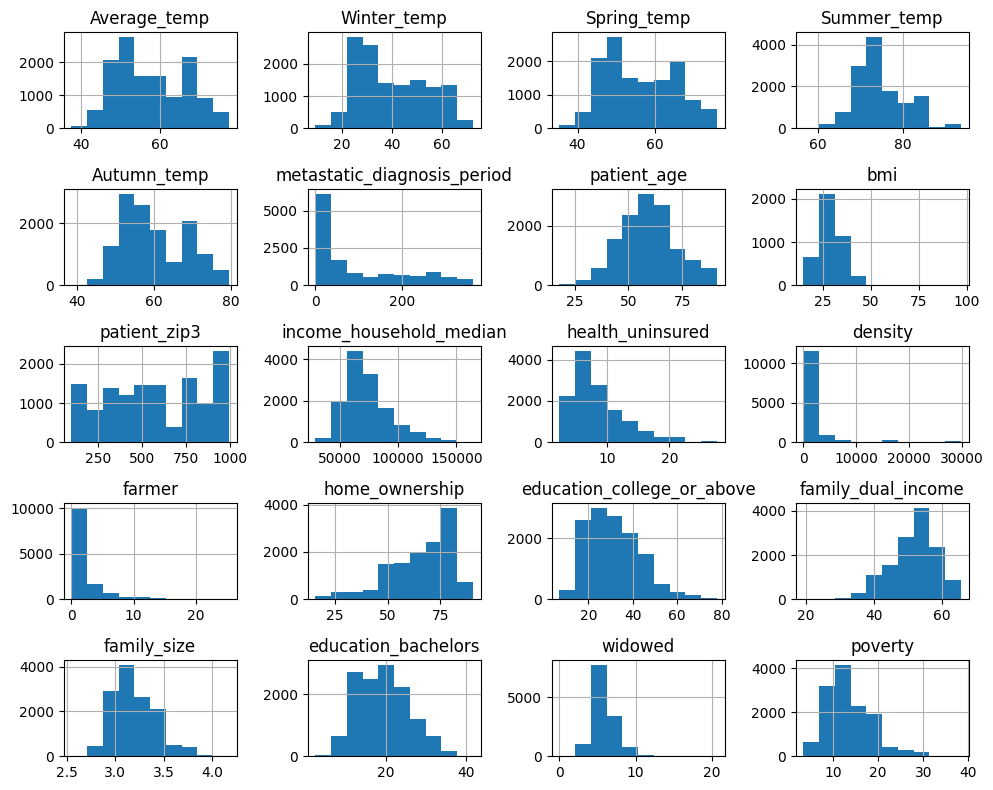

In [19]:
# Histograms for numerical features
Train.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

# Handling Missing Data

In [20]:
# Train missing values by column
missing_values = Train.isna().sum()
missing_values

Average_temp                           0
Winter_temp                            0
Spring_temp                            0
Summer_temp                            0
Autumn_temp                            0
metastatic_diagnosis_period            0
patient_age                            0
bmi                                 9071
patient_race                        6657
patient_state                          0
patient_zip3                           0
Region                                 0
Division                               0
breast_cancer_diagnosis_code           0
metastatic_cancer_diagnosis_code       0
income_household_median                5
payer_type                          1765
health_uninsured                       0
density                                0
farmer                                 5
home_ownership                         5
education_college_or_above             0
family_dual_income                     5
family_size                            5
education_bachel

In [21]:
# Test missing values by column
missing_values = Test.isna().sum()
missing_values

Average_temp                           0
Winter_temp                            0
Spring_temp                            0
Summer_temp                            0
Autumn_temp                            0
patient_age                            0
bmi                                 3941
patient_race                        2785
patient_state                          0
patient_zip3                           0
Region                                 0
Division                               0
breast_cancer_diagnosis_code           0
metastatic_cancer_diagnosis_code       0
income_household_median                0
payer_type                           785
health_uninsured                       0
density                                0
farmer                                 0
home_ownership                         0
education_college_or_above             0
family_dual_income                     0
family_size                            0
education_bachelors                    0
widowed         

### Handling NaN vlaues for BMI

*Final model does not use BMI (significantly worsens the model).*

In [22]:
print(Train['bmi'].isnull().sum())

9071


In [23]:
print(Test['bmi'].isnull().sum())

3941


#### Imputation based on state and age based average

In [24]:
# Group by both patient_state and age to calculate average
average_bmi_by_state_age = Train.groupby(['patient_state', 'patient_age'])['bmi'].mean().reset_index()
Train = pd.merge(Train, average_bmi_by_state_age, on=['patient_state', 'patient_age'], how='left', suffixes=('', '_average'))
Test = pd.merge(Test, average_bmi_by_state_age, on=['patient_state', 'patient_age'], how='left', suffixes=('', '_average'))

# Fill missing BMI
Train['bmi'] = Train['bmi'].fillna(Train['bmi_average'])
Test['bmi'] = Test['bmi'].fillna(Test['bmi_average'])

# Drop the redundant columns
Train.drop(['bmi_average'], axis=1, inplace=True)
Test.drop(['bmi_average'], axis=1, inplace=True)

#### Imputation using an age based average

In [25]:
# Group by age to calculate average
average_bmi_by_age = Train.groupby(['patient_age'])['bmi'].mean().reset_index()
Train = pd.merge(Train, average_bmi_by_age, on=['patient_age'], how='left', suffixes=('', '_average'))
Test = pd.merge(Test, average_bmi_by_age, on=['patient_age'], how='left', suffixes=('', '_average'))

# Fill missing BMI
Train['bmi'] = Train['bmi'].fillna(Train['bmi_average'])
Test['bmi'] = Test['bmi'].fillna(Test['bmi_average'])

# Drop the redundant columns
Train.drop(['bmi_average'], axis=1, inplace=True)
Test.drop(['bmi_average'], axis=1, inplace=True)

#### Imputation using the mean

In [26]:
# using the dataset mean
average_bmi = Train['bmi'].mean()
Train['bmi'].fillna(average_bmi, inplace=True)
Test['bmi'].fillna(average_bmi, inplace=True)

### Handling NaN values for Payer Type

In [27]:
print(Train['payer_type'].isnull().sum())

1765


In [28]:
Train['payer_type'].unique()

array(['COMMERCIAL', nan, 'MEDICAID', 'MEDICARE ADVANTAGE'], dtype=object)

In [29]:
Train['payer_type'].fillna('none', inplace=True)

In [30]:
Test['payer_type'].fillna('none', inplace=True)

### Handling NaN values for Patient Race

In [31]:
print(Train['patient_race'].isnull().sum())

6657


In [32]:
Train['patient_race'].fillna('unknown', inplace=True)

In [33]:
Test['patient_race'].fillna('unknown', inplace=True)

In [34]:
Train

,Average_temp,Winter_temp,Spring_temp,Summer_temp,Autumn_temp,metastatic_diagnosis_period,patient_age,bmi,patient_race,patient_state,...,health_uninsured,density,farmer,home_ownership,education_college_or_above,family_dual_income,family_size,education_bachelors,widowed,poverty
0,59.083750,38.928889,58.129444,78.365556,60.911111,191,39,27.742296,unknown,AR,...,8.06,82.63,5.31,72.11,13.32,43.99,3.01,9.21,8.66,19.27
1,56.399028,35.376111,55.996667,76.002222,58.221111,33,55,35.360000,White,IL,...,6.93,51.79,5.21,76.71,18.49,41.41,3.17,12.46,8.17,16.94
2,70.011250,57.466667,67.862778,82.916667,71.798889,157,59,30.146818,unknown,CA,...,8.07,700.34,0.44,66.82,22.32,52.89,3.80,13.92,4.95,12.72
3,66.694861,60.693333,63.912222,71.974444,70.199444,146,59,30.146818,Hispanic,CA,...,10.34,5294.33,0.01,31.50,37.58,55.53,3.44,23.89,4.77,20.76
4,61.847361,54.418889,60.406667,68.240556,64.323333,286,71,26.574545,unknown,CA,...,6.54,400.48,1.46,58.81,31.14,51.88,3.09,19.14,5.01,10.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,54.405694,35.226111,51.873333,74.336667,56.186667,106,59,32.752857,Hispanic,PA,...,6.29,5512.17,0.00,52.53,38.26,50.73,3.09,21.29,5.43,20.18
13169,66.802083,50.260556,66.135000,82.684444,68.128333,92,73,30.670000,unknown,TX,...,17.59,204.69,5.86,73.84,19.39,46.86,3.21,12.31,6.67,13.47
13170,68.743750,60.765556,66.255556,76.016111,71.937778,0,19,39.607500,unknown,CA,...,7.02,2295.94,0.03,61.46,35.98,61.74,3.62,23.74,4.65,10.11
13171,48.475694,25.986111,46.163889,69.866111,51.886667,330,52,29.576250,unknown,MI,...,4.37,743.56,0.53,75.67,34.02,51.79,3.13,20.10,5.50,12.12


## Handling NaN values for income household median

In [35]:
# Impute missing values based on state median income
state_median_income = Train.groupby('patient_state')['income_household_median'].transform('median')
Train['income_household_median'].fillna(state_median_income, inplace=True)
Test['income_household_median'].fillna(state_median_income, inplace=True)

In [36]:
print(Train['income_household_median'].isnull().sum())
print(Test['income_household_median'].isnull().sum())

0
0


## Handling NaN values for farmer

In [37]:
# Impute missing values based on state median income
farmer = Train['farmer'].median()
Train['farmer'].fillna(state_median_income, inplace=True)
Test['farmer'].fillna(state_median_income, inplace=True)

In [38]:
print(Train['farmer'].isnull().sum())

0


## Removing other NaNs

In [39]:
# Removing NaN values from other features
feature_columns = ['metastatic_diagnosis_period','patient_age','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                   'health_uninsured','density','farmer','home_ownership','education_college_or_above']

Train = Train.dropna(subset=feature_columns)

In [40]:
# Removing NaN values from other features
feature_columns = ['Average_temp','patient_age','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'income_household_median',
                   'health_uninsured','density','farmer','home_ownership','education_college_or_above']

Test = Test.dropna(subset=feature_columns)

# Correlation HeatMap for Chosen Numerical Features and Target Feature

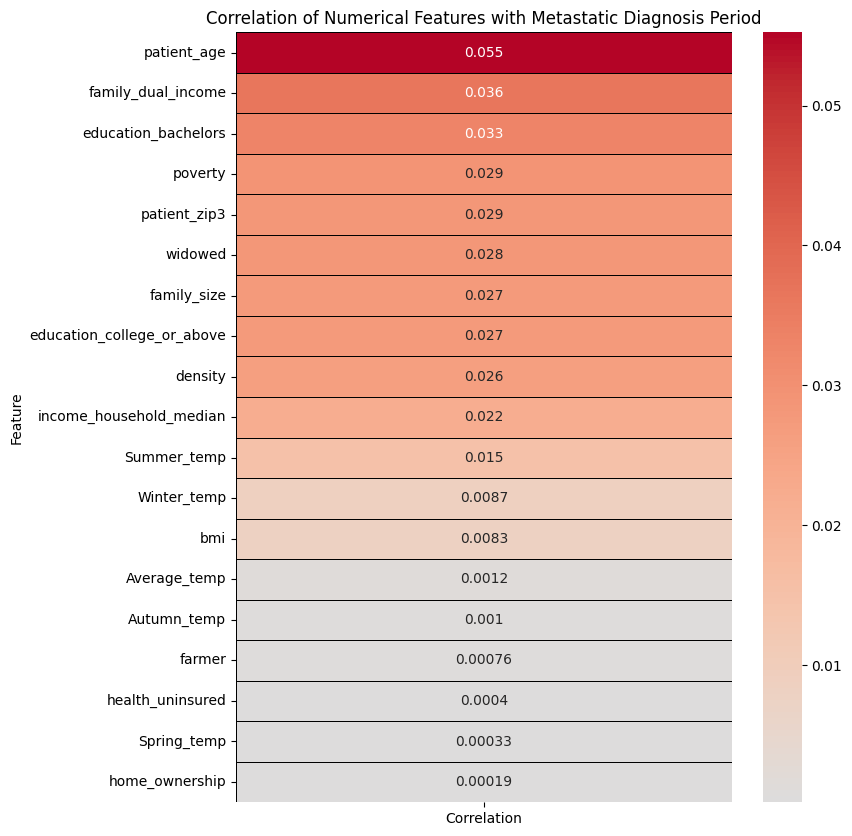

In [41]:
# Calculate correlations between numerical columns and 'metastatic_diagnosis_period' column
numerical_columns = Train.select_dtypes(include=['int', 'float']).columns
correlation_with_metastatic_cancer = Train[numerical_columns].corrwith(Train['metastatic_diagnosis_period'])

# Absolute value of correlations and sorting them in descending order
correlation_with_metastatic_cancer = correlation_with_metastatic_cancer.abs().sort_values(ascending=False)

# Convert the correlation series to a DataFrame
correlation_df = correlation_with_metastatic_cancer.to_frame().reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df = correlation_df[correlation_df['Feature'] != 'metastatic_diagnosis_period']
correlation_df.set_index('Feature', inplace=True)

# Heatmap
plt.figure(figsize=(8,10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='black')
plt.title('Correlation of Numerical Features with Metastatic Diagnosis Period')
plt.show()

#  Boxplots of Distribution of Metastatic Diagnosis Period Across Chosen Categorical Features

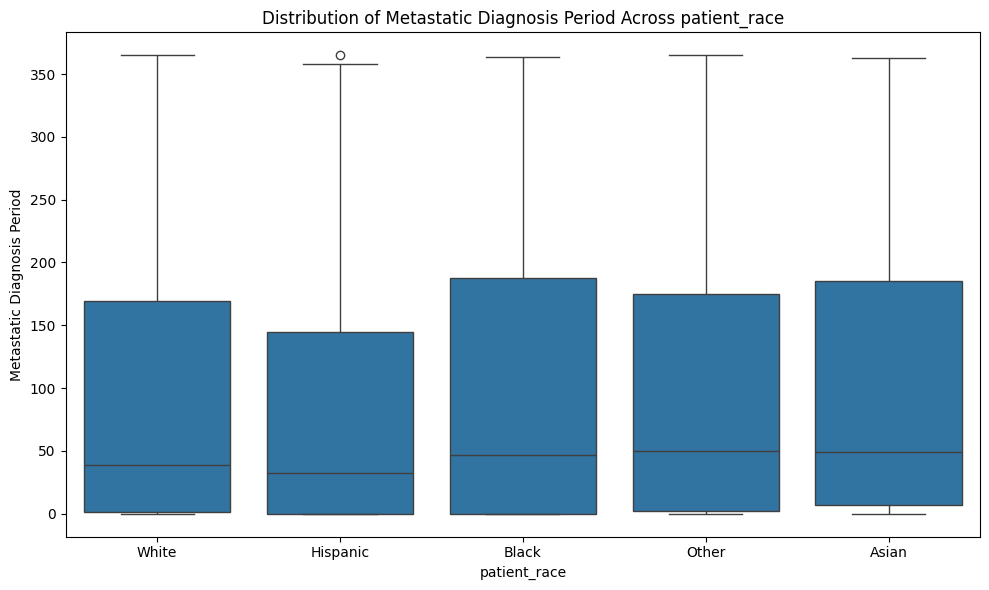

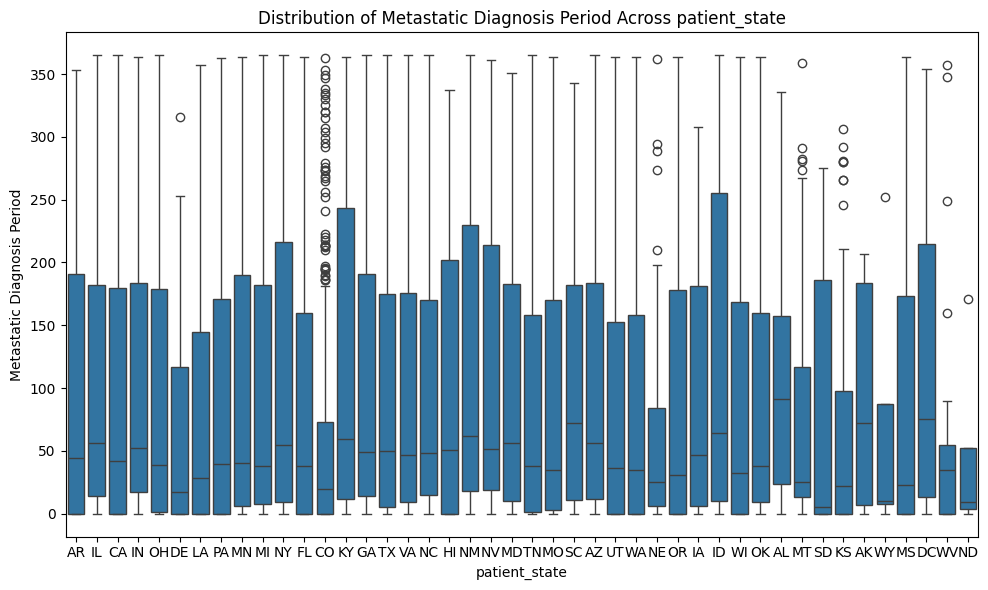

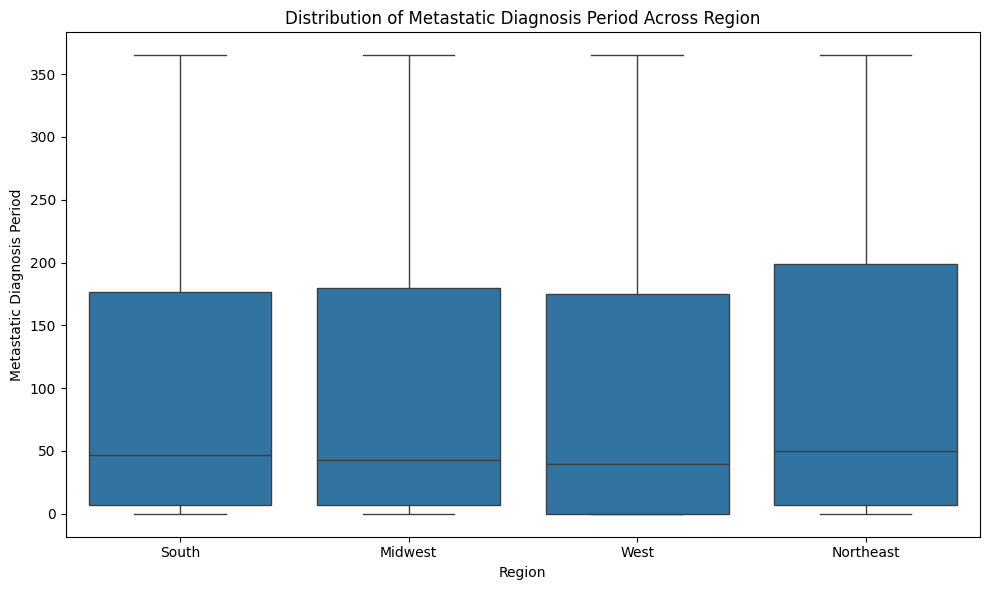

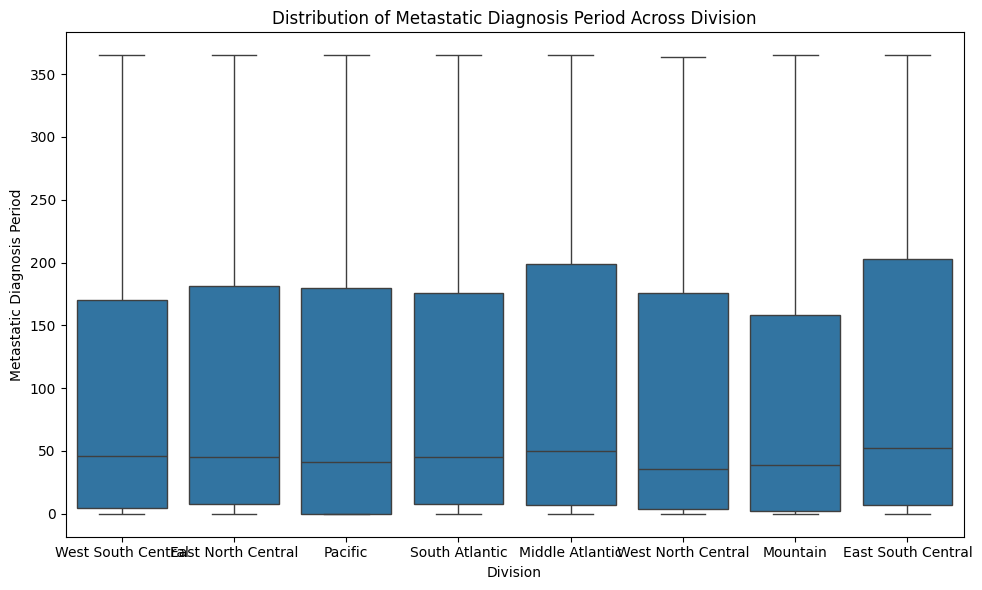

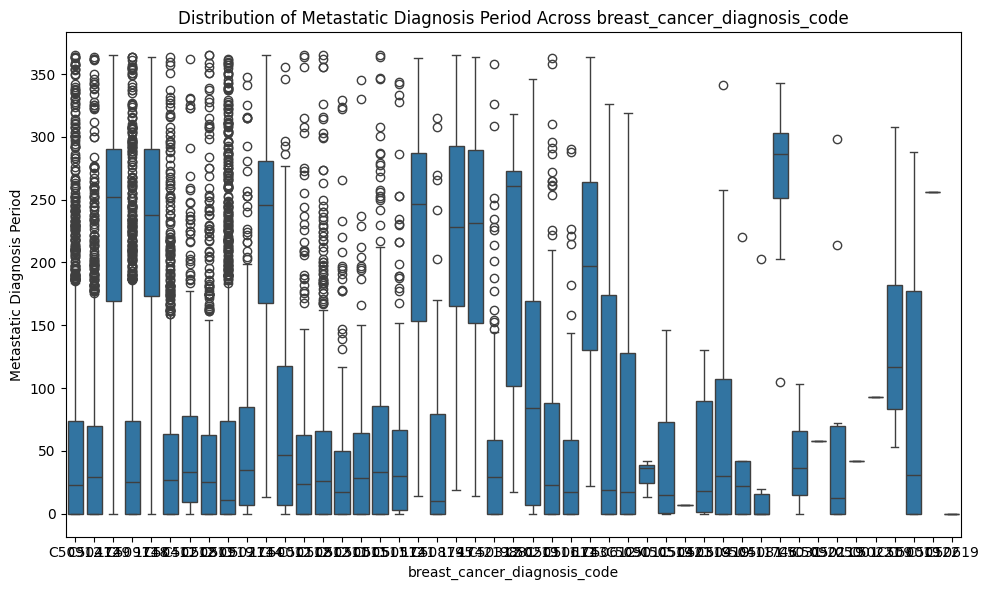

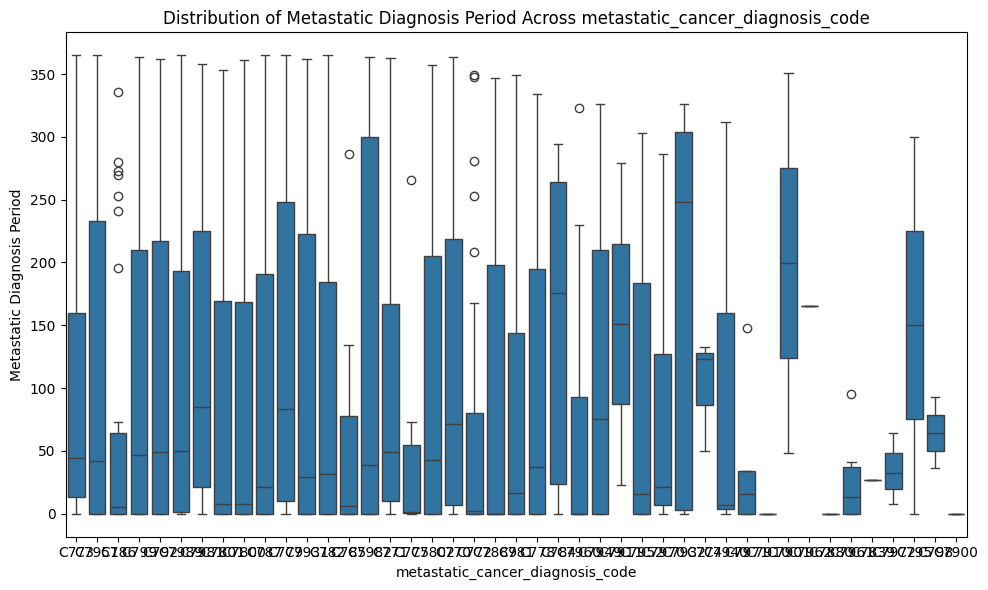

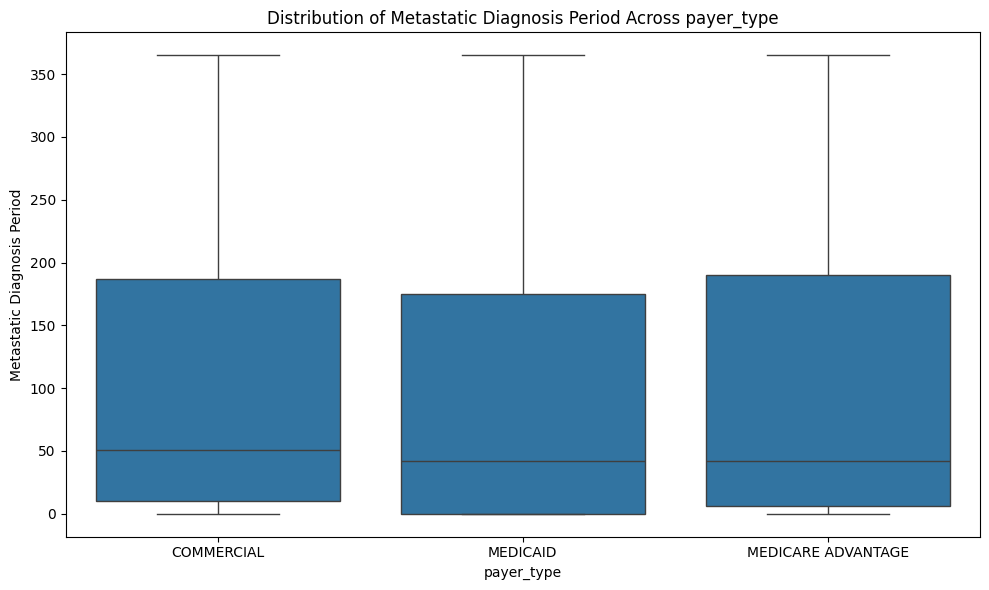

In [42]:
# Categorical features
categorical_columns = Train.select_dtypes(exclude=['int', 'float']).columns.tolist()

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='metastatic_diagnosis_period', data=train)
    plt.title(f'Distribution of Metastatic Diagnosis Period Across {col}')
    plt.xlabel(col)
    plt.ylabel('Metastatic Diagnosis Period')
    plt.tight_layout()
    plt.show()

# Preparing the Test, Train split

In [43]:
y = Train.loc[:,'metastatic_diagnosis_period']

In [44]:
# My Feature matrix
selected_columns = ['Average_temp','patient_age','bmi','patient_race','patient_state','patient_zip3' ,'Region', 'Division','breast_cancer_diagnosis_code',
                    'metastatic_cancer_diagnosis_code', 'income_household_median','payer_type','health_uninsured','density','farmer','home_ownership','education_college_or_above']

X = Train.loc[:, selected_columns]
X

,Average_temp,patient_age,bmi,patient_race,patient_state,patient_zip3,Region,Division,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,income_household_median,payer_type,health_uninsured,density,farmer,home_ownership,education_college_or_above
0,59.083750,39,27.742296,unknown,AR,724,South,West South Central,C50912,C773,44483.35,COMMERCIAL,8.06,82.63,5.31,72.11,13.32
1,56.399028,55,35.360000,White,IL,629,Midwest,East North Central,C50412,C773,51796.79,none,6.93,51.79,5.21,76.71,18.49
2,70.011250,59,30.146818,unknown,CA,925,West,Pacific,1749,C773,78696.87,COMMERCIAL,8.07,700.34,0.44,66.82,22.32
3,66.694861,59,30.146818,Hispanic,CA,900,West,Pacific,C50911,C773,69266.69,MEDICAID,10.34,5294.33,0.01,31.50,37.58
4,61.847361,71,26.574545,unknown,CA,934,West,Pacific,1748,C7951,82314.64,COMMERCIAL,6.54,400.48,1.46,58.81,31.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,54.405694,59,32.752857,Hispanic,PA,191,Northeast,Middle Atlantic,C50911,C773,62665.53,MEDICAID,6.29,5512.17,0.00,52.53,38.26
13169,66.802083,73,30.670000,unknown,TX,757,South,West South Central,1749,C7951,59680.27,COMMERCIAL,17.59,204.69,5.86,73.84,19.39
13170,68.743750,19,39.607500,unknown,CA,928,West,Pacific,C50819,C799,102741.60,COMMERCIAL,7.02,2295.94,0.03,61.46,35.98
13171,48.475694,52,29.576250,unknown,MI,481,Midwest,East North Central,1742,C779,76481.07,COMMERCIAL,4.37,743.56,0.53,75.67,34.02


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Training Base Models

## CatBoost

In [46]:
# Categorical Features
categorical_columns = ['patient_race', 'patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define the CatBoost model
catboost = CatBoostRegressor(iterations=151,
                             learning_rate=0.125,
                             depth=6,
                             loss_function='RMSE',
                             random_state=42)

# Create a pipeline with the preprocessor and CatBoost model
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', catboost)
])

# Train the model
catboost_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_catboost = catboost_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_catboost, squared=False)
print("RMSE:", rmse)

0:	learn: 104.4239253	total: 54ms	remaining: 8.1s
1:	learn: 100.5982228	total: 60.4ms	remaining: 4.5s
2:	learn: 97.2454446	total: 66.5ms	remaining: 3.28s
3:	learn: 94.6599873	total: 72.4ms	remaining: 2.66s
4:	learn: 92.5668795	total: 78.2ms	remaining: 2.28s
5:	learn: 90.7241592	total: 84.2ms	remaining: 2.04s
6:	learn: 89.1291794	total: 90ms	remaining: 1.85s
7:	learn: 88.0830839	total: 95.9ms	remaining: 1.71s
8:	learn: 87.2618435	total: 102ms	remaining: 1.61s
9:	learn: 86.5444133	total: 107ms	remaining: 1.51s
10:	learn: 86.0076263	total: 115ms	remaining: 1.47s
11:	learn: 85.5693476	total: 121ms	remaining: 1.4s
12:	learn: 85.2178060	total: 127ms	remaining: 1.35s
13:	learn: 84.9829759	total: 133ms	remaining: 1.3s
14:	learn: 84.7082770	total: 139ms	remaining: 1.26s
15:	learn: 84.4322325	total: 145ms	remaining: 1.22s
16:	learn: 84.2711967	total: 150ms	remaining: 1.19s
17:	learn: 84.0904939	total: 156ms	remaining: 1.15s
18:	learn: 83.9162190	total: 162ms	remaining: 1.13s
19:	learn: 83.783956

## Adaboost

In [47]:
# Categorical Features
categorical_columns = ['patient_race', 'patient_state', 'patient_zip3', 'Region', 'Division',
                       'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age', 'income_household_median',
                               'health_uninsured', 'density', 'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define AdaBoost
estimator = DecisionTreeRegressor(max_depth=5)
adaboost = AdaBoostRegressor(estimator=estimator, n_estimators=100, learning_rate=0.01, random_state=42)

# Create a pipeline with the preprocessor and AdaBoost
ada_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', adaboost)
])

# Train the model
ada_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_ada, squared=False)
print("RMSE:", rmse)

RMSE: 84.60756397662891


## LightGBM

In [48]:
import lightgbm as lgb

# Categorical Features
categorical_columns = ['patient_race', 'patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define the LightGBM model
lgbm = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.13,
    max_depth=2,
    min_child_samples=4,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=42
)

# Create a pipeline with the preprocessor and LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgbm)
])

# Train the model
lgbm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_lgbm, squared=False)
print("RMSE:", rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 11851, number of used features: 712
[LightGBM] [Info] Start training from score 96.816218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

##Linear Regression

In [49]:
# Categorical Features
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define the glm model
lm = LinearRegression(fit_intercept=True)

# Create a pipeline with the preprocessor and glm model
lm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lm)
])

# Train the model
lm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lm = lm_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_lm, squared=False)
print("RMSE:", rmse)

RMSE: 88.13706231667666


## ElasticNet

In [50]:
# Categorical Features
categorical_columns = ['patient_race', 'patient_state','patient_zip3', 'Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median', 'health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define the Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=1, random_state=42)

# Create a pipeline with the preprocessor and Elastic Net
elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', elastic_net)
])

# Train the model
elastic_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_elastic = elastic_pipeline.predict(X_test)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
print("RMSE:", rmse)

RMSE: 83.66899285852196


## RFR

In [51]:
# Categorical Features
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define the RFR model
rfr = RandomForestRegressor(
    n_estimators=175,
    random_state=42,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=23,
    max_features='auto',
    bootstrap=True,
    criterion='squared_error'
)

# Create a pipeline with the preprocessor and CatBoost
rfr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rfr)
])

# Train the model
rfr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rfr = rfr_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_rfr, squared=False)
print("RMSE:", rmse)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSE: 83.55383706221777


## SVR

In [52]:
# Categorical Features
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define the SVR model
svr = SVR(
    kernel='rbf',
    C=115,
    epsilon=48,
    gamma='scale',
    shrinking=True,
    tol=0.001,
    verbose=False,
    max_iter=-1

)

# Create a pipeline with the preprocessor and CatBoost model
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svr)
])

# Train the model
svr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_svr, squared=False)
print("RMSE:", rmse)

RMSE: 85.05438476939678


## XRT

In [53]:
# Categorical Features
categorical_columns = ['patient_race','patient_state', 'patient_zip3','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Define the XRT model
xrt = ExtraTreesRegressor(
    n_estimators=100,
    criterion='squared_error',
    min_samples_split=240,
    min_samples_leaf=10,
    random_state=None,
    verbose=0,
)

# Create a pipeline with the preprocessor and XRT model
xrt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xrt)
])

# Train the model
xrt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xrt = xrt_pipeline.predict(X_test)

# Evaluate Model
rmse = mean_squared_error(y_test, y_pred_xrt, squared=False)
print("RMSE:", rmse)

RMSE: 83.35489270641442


## Feedforward NN

In [54]:
# Categorical Features
categorical_columns = ['patient_race', 'patient_state','Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type']

# Preprocessing
transformers = [
    ('num', StandardScaler(), ['Average_temp', 'patient_age',
                               'income_household_median','health_uninsured', 'density',
                               'farmer', 'home_ownership',
                               'education_college_or_above']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
]

preprocessor = ColumnTransformer(transformers)

# Fit preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]

# Random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

# Define model hyperparameters
num_hidden_layers = 2
hidden_units = 55
output_dim = 1
activation = 'relu'

# Lists to store training loss values
train_losses = []
train_rmse = []
test_rmse = []

# Early stopping parameters
patience = 10
min_delta = 0.001
best_rmse = float('inf')
no_improvement_counter = 0

# Define the Feedforward model
class NN(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, hidden_units, output_dim, activation='relu'):
        super(NN, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_units)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(num_hidden_layers)])
        self.output_layer = nn.Linear(hidden_units, output_dim)
        if activation == 'relu':
            self.activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation_function = nn.Sigmoid()
        else:
            raise ValueError("Activation function '{}' not supported.".format(activation))

    def forward(self, x):
        x = self.activation_function(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation_function(layer(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
model = NN(input_dim, num_hidden_layers, hidden_units, output_dim, activation)

# Define the hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0)
criterion = nn.MSELoss()
num_epochs = 200
batch_size = 32

# Convert data to tensors
X_train_tensor = torch.tensor(csr_matrix(X_train_processed).toarray()).float()
y_train_tensor = torch.tensor(y_train.values.astype('float32'))
X_test_tensor = torch.tensor(csr_matrix(X_test_processed).toarray()).float()
y_test_tensor = torch.tensor(y_test.values.astype('float32'))

# Train the model
for epoch in range(num_epochs):
    epoch_losses = []
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y_pred = model(batch_X)
        loss = criterion(batch_y_pred, y_train_tensor[i:i+batch_size].unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # Calculate the average loss for the epoch
    epoch_loss_avg = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(epoch_loss_avg)

    # Calculate predictions for the training set
    y_pred_train_tensor = model(X_train_tensor)
    y_pred_train = y_pred_train_tensor.detach().numpy().flatten()

    # Calculate RMSE for training set
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    train_rmse.append(rmse_train)

    # Calculate predictions for the test set
    y_pred_test_tensor = model(X_test_tensor)
    y_pred_test = y_pred_test_tensor.detach().numpy().flatten()

    # Calculate RMSE for test set
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    test_rmse.append(rmse_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}, Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}')

    # Check for improvement in test RMSE
    if rmse_test < best_rmse - min_delta:
        best_rmse = rmse_test
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    # Check if early stopping criteria are met
    if no_improvement_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} as no improvement in test RMSE for {patience} consecutive epochs.')
        break

y_pred_train_tensor = model(X_train_tensor)

# Convert predictions to numpy array
y_pred_train = y_pred_train_tensor.detach().numpy().flatten()

# Calculate RMSE for training set
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("RMSE for Training Set:", rmse_train)

# Calculate predictions for the test set
y_pred_test_tensor = model(X_test_tensor)

# Convert predictions to numpy array
y_pred_test_NN = y_pred_test_tensor.detach().numpy().flatten()

# Calculate RMSE for test set
rmse_test = mean_squared_error(y_test, y_pred_test_NN, squared=False)
print("RMSE for Test Set:", rmse_test)

Epoch [1/200], Loss: 21023.1048, Train RMSE: 140.3270, Test RMSE: 136.9941
Epoch [2/200], Loss: 14648.9286, Train RMSE: 106.8831, Test RMSE: 105.0051
Epoch [3/200], Loss: 11059.2644, Train RMSE: 103.5328, Test RMSE: 102.1983
Epoch [4/200], Loss: 10436.2310, Train RMSE: 100.6027, Test RMSE: 99.6500
Epoch [5/200], Loss: 9831.0613, Train RMSE: 97.4780, Test RMSE: 96.9365
Epoch [6/200], Loss: 9196.3671, Train RMSE: 94.0874, Test RMSE: 94.0073
Epoch [7/200], Loss: 8548.1809, Train RMSE: 90.6421, Test RMSE: 91.0487
Epoch [8/200], Loss: 7953.9012, Train RMSE: 87.6204, Test RMSE: 88.4737
Epoch [9/200], Loss: 7497.0618, Train RMSE: 85.4799, Test RMSE: 86.6804
Epoch [10/200], Loss: 7209.2986, Train RMSE: 84.2179, Test RMSE: 85.6596
Epoch [11/200], Loss: 7050.0617, Train RMSE: 83.5290, Test RMSE: 85.1367
Epoch [12/200], Loss: 6961.7442, Train RMSE: 83.1237, Test RMSE: 84.8490
Epoch [13/200], Loss: 6906.7450, Train RMSE: 82.8528, Test RMSE: 84.6667
Epoch [14/200], Loss: 6868.1251, Train RMSE: 82.6

## NN - Processing and Predicting on Train set

In [55]:
# Preprocess the test data
Train_processed = preprocessor.transform(Train)

# Convert into PyTorch tensor
Train_tensor = torch.tensor(csr_matrix(Train_processed).toarray()).float()

# Get predictions
with torch.no_grad():
    Train_pred_tensor = model(Train_tensor)

# Convert to numpy array
Train_pred = Train_pred_tensor.detach().numpy().flatten()


## NN - Processing and Predicting on Test set

In [56]:
# Preprocess the test data
Test_processed = preprocessor.transform(Test)

# Convert into PyTorch tensor
Test_tensor = torch.tensor(csr_matrix(Test_processed).toarray()).float()

# Get predictions
with torch.no_grad():
    Test_pred_tensor = model(Test_tensor)

# Convert to numpy array
Test_pred = Test_pred_tensor.detach().numpy().flatten()

In [57]:
Test_pred

array([233.94524 ,  63.711086, 201.77832 , ..., 252.46626 ,  85.31277 ,
        54.301895], dtype=float32)

# Meta-Features Ensemble


**Base leaners** <br>

1) Catboost <br>
2) Linear Regression Model <br>
3) Random Forest Regressor <br>
4) Sector Vector Regressor <br>
5) Extreme Random Trees <br>
6) FeedForward Neural Network <br>
7) Adaboost <br>
8) Elastic Net <br>

**Meta leaner** <br>
1) Linear Regresssion

In [58]:
# Train Meta-Model
meta_features = np.column_stack(((y_pred_catboost,y_pred_lm, y_pred_rfr, y_pred_svr, y_pred_xrt, y_pred_test_NN, y_pred_ada,y_pred_elastic)))
meta_model = LinearRegression()
meta_model.fit(meta_features, y_test)

# Calculate Trianing RMSE
rmse_predictions = meta_model.predict(meta_features)
rmse = mean_squared_error(y_test, rmse_predictions, squared=False)
print("RMSE:", rmse)

RMSE: 82.63326994859966


In [59]:
# Meta Model Predictions
preds_meta_features = np.column_stack((catboost_pipeline.predict(Test),lm_pipeline.predict(Test),rfr_pipeline.predict(Test),svr_pipeline.predict(Test),xrt_pipeline.predict(Test),Test_pred, ada_pipeline.predict(Test),elastic_pipeline.predict(Test)))
final_predictions = meta_model.predict(preds_meta_features)
final_predictions

array([219.3562407 ,  59.32409036, 199.79440578, ..., 213.54631773,
        78.38990643,  53.0858939 ])

## Meta-Feature Model Visualisations

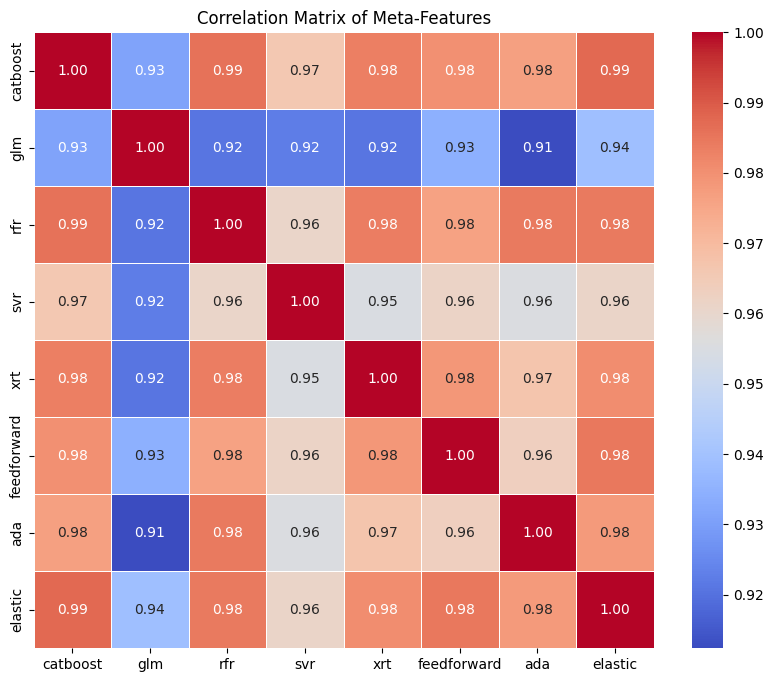

In [60]:
# Base learners
base_learner_names = ['catboost', 'glm', 'rfr', 'svr', 'xrt', 'feedforward', 'ada', 'elastic']
df_rmse_meta_features = pd.DataFrame(meta_features, columns=base_learner_names)

# Correlation matrix
correlation_matrix = df_rmse_meta_features.corr().abs()

# Correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Meta-Features')
plt.show()

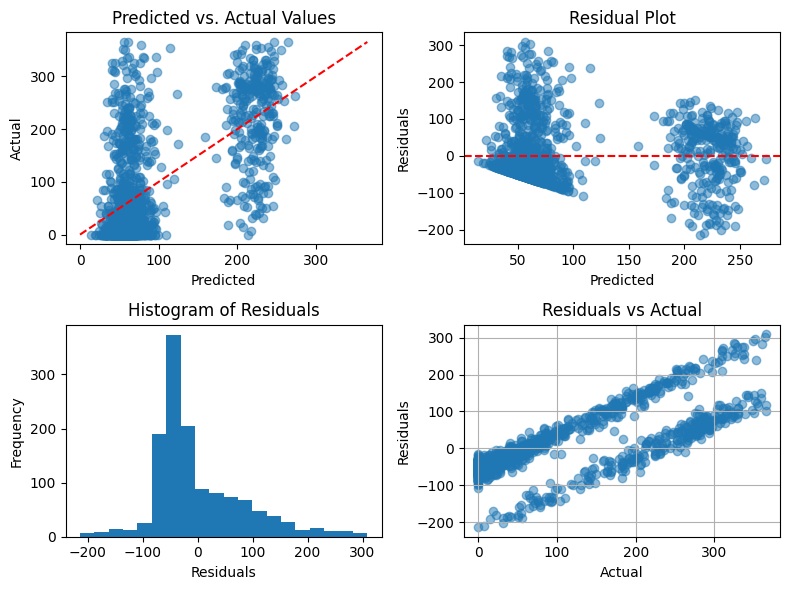

In [61]:
plt.figure(figsize=(8, 6))

# Predicted vs. Actual
plt.subplot(2, 2, 1)
plt.scatter(meta_model.predict(meta_features), y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual Values')

# Residual plot
plt.subplot(2, 2, 2)
residuals = y_test - meta_model.predict(meta_features)
plt.scatter(meta_model.predict(meta_features), residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of residuals
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Residuals vs y_test
plt.subplot(2, 2, 4)
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual')
plt.grid(True)

plt.tight_layout()
plt.show()

# Prediction Mistakes Probability Model
Training a Model to create a new feature of the probability of inccorect predictions

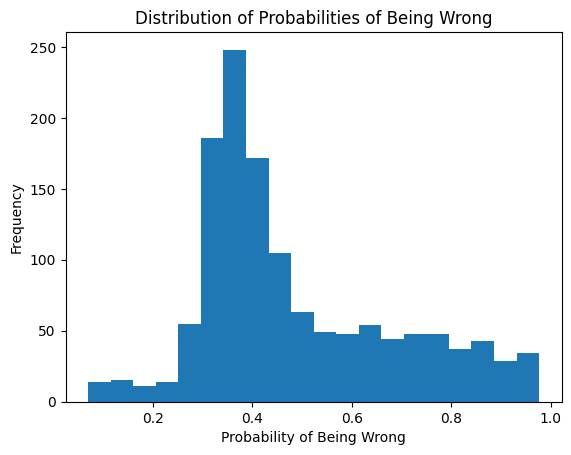

In [62]:
# Probability of a prediction being wrong using normalisation
normalized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
prob_wrong = expit(normalized_residuals)

plt.hist(prob_wrong, bins=20)
plt.xlabel('Probability of Being Wrong')
plt.ylabel('Frequency')
plt.title('Distribution of Probabilities of Being Wrong')
plt.show()

In [63]:
# Train
prediction_mistakes = LinearRegression()
prediction_mistakes.fit(meta_features, prob_wrong)
rmse_predictions = prediction_mistakes.predict(meta_features)
rmse = mean_squared_error(prob_wrong, rmse_predictions, squared=False)
print("RMSE:", rmse)

#predictions on Test set
preds_meta_features = np.column_stack((catboost_pipeline.predict(Test),lm_pipeline.predict(Test),rfr_pipeline.predict(Test),svr_pipeline.predict(Test),xrt_pipeline.predict(Test),Test_pred, ada_pipeline.predict(Test),elastic_pipeline.predict(Test)))
Test_pred_mistake = prediction_mistakes.predict(preds_meta_features)
Test_pred_mistake

RMSE: 0.1976868581743148


array([0.45569761, 0.48171363, 0.50898   , ..., 0.51258504, 0.48044115,
       0.48380948])

# Final Model

Incorporates all base learner predictions with prediction mistake probability.

In [64]:
# Train the Final Model
ensemble_features = np.column_stack((y_pred_catboost, y_pred_lm, y_pred_rfr, y_pred_svr, y_pred_xrt, y_pred_test_NN, y_pred_ada, y_pred_elastic,prob_wrong,))
final_model = LinearRegression()
final_model.fit(ensemble_features, y_test)
rmse_predictions = final_model.predict(ensemble_features)
rmse = mean_squared_error(y_test, rmse_predictions, squared=False)
print("RMSE:", rmse)

RMSE: 13.1738632248849


In [66]:
# Final Predictions
preds_meta_features = np.column_stack((catboost_pipeline.predict(Test),lm_pipeline.predict(Test),rfr_pipeline.predict(Test),svr_pipeline.predict(Test),xrt_pipeline.predict(Test),Test_pred, ada_pipeline.predict(Test),elastic_pipeline.predict(Test),Test_pred_mistake))
final_predictions1 = final_model.predict(preds_meta_features)
final_predictions1

array([219.3562407 ,  59.32409036, 199.79440578, ..., 213.54631773,
        78.38990643,  53.0858939 ])

## Final Model Visualisations

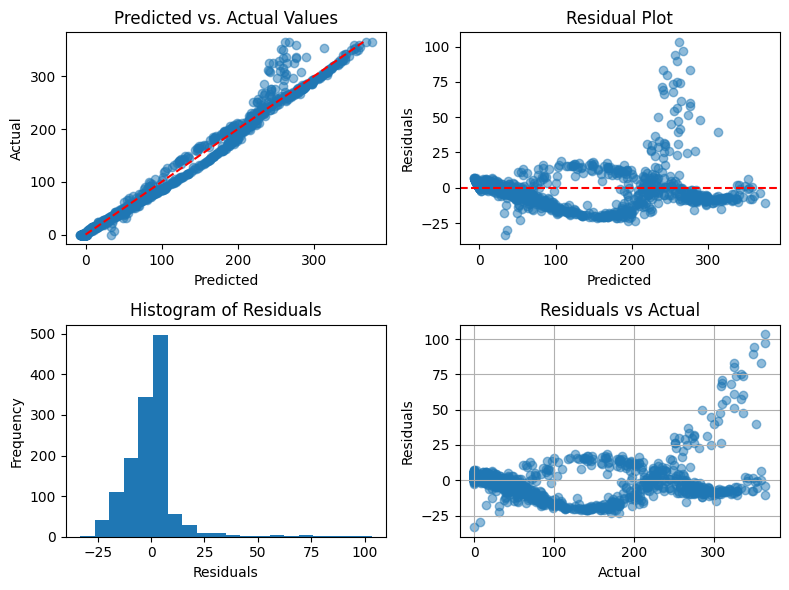

In [67]:
plt.figure(figsize=(8, 6))

# Predicted vs. Actual
plt.subplot(2, 2, 1)
plt.scatter(final_model.predict(ensemble_features), y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual Values')

# Residual plot
plt.subplot(2, 2, 2)
residuals = y_test - final_model.predict(ensemble_features)
plt.scatter(final_model.predict(ensemble_features), residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of residuals
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Residuals vs y_test
plt.subplot(2, 2, 4)
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual')
plt.grid(True)

plt.tight_layout()
plt.show()

# Final Submission CSV

In [70]:
# DataFrame to store patient IDs and predictions
submission_df = pd.DataFrame({
    'patient_id': test['patient_id'],
    'metastatic_diagnosis_period': final_predictions1,
})

# Convert patient_id to integer
submission_df['patient_id'] = submission_df['patient_id'].astype(int)

# Round prediction and convert to integer
submission_df['metastatic_diagnosis_period'] = submission_df['metastatic_diagnosis_period'].round().astype(int)

# Convert to a CSV file
submission_df.to_csv('submission.csv', index=False)
submission_df

,patient_id,metastatic_diagnosis_period
0,730681,219
1,334212,59
2,571362,200
3,907331,169
4,208382,43
...,...,...
5641,649011,35
5642,869024,66
5643,304800,214
5644,267406,78
